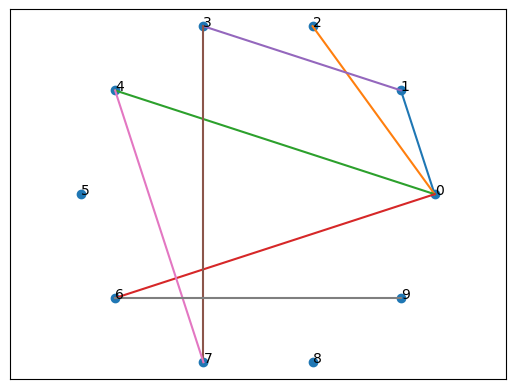

In [4]:
import matplotlib.pyplot as plt
import math
import random

# Number of points
n = 10

# Generate decagon positions
angles = [2*math.pi*i/n for i in range(n)]
points = [(math.cos(a), math.sin(a)) for a in angles]

# Random edges
edges = []
for i in range(n):
    for j in range(i+1, n):
        if random.random() < 0.2:  # ~20% chance of connection
            edges.append((i, j))

# Plot points
x, y = zip(*points)
plt.figure()
plt.scatter(x, y)

# Plot edges
for i, j in edges:
    xi, yi = points[i]
    xj, yj = points[j]
    plt.plot([xi, xj], [yi, yj])

# Label points
for idx, (xi, yi) in enumerate(points):
    plt.text(xi, yi, str(idx))

plt.axis('equal')
plt.xticks([])  # remove x-axis numbers
plt.yticks([])  # remove y-axis numbers
plt.show()


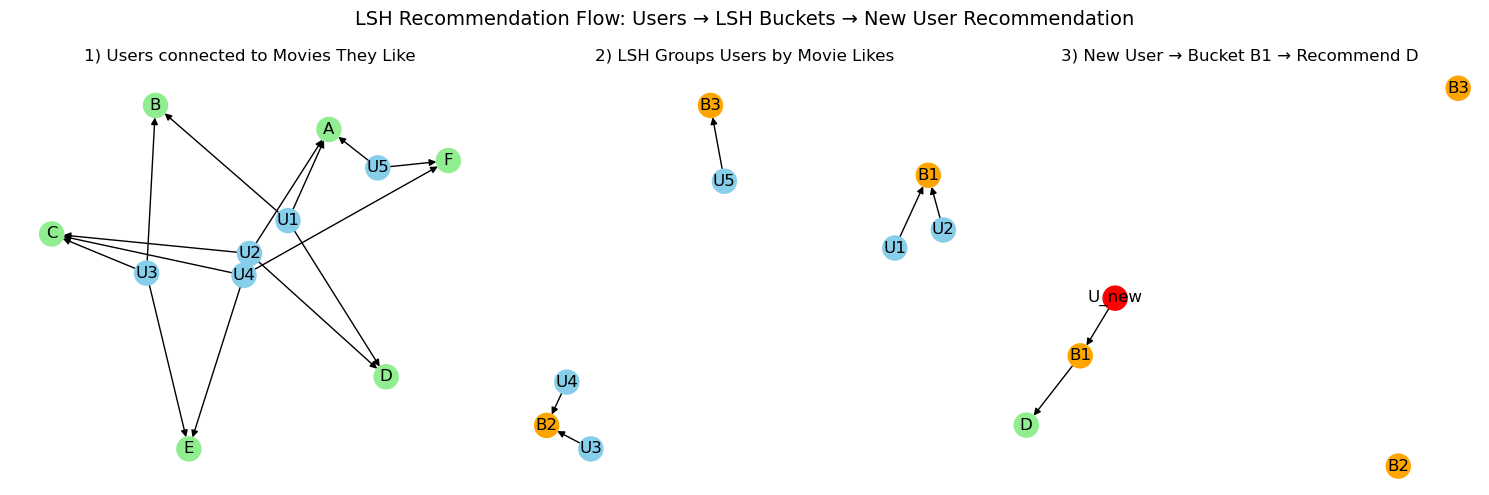

In [11]:
import matplotlib.pyplot as plt
import networkx as nx

# ===== Data =====
users = ["U1","U2","U3","U4","U5"]
movies = ["A","B","C","D","E","F"]

# User movie likes
likes = {
    "U1":["A","B","D"],
    "U2":["A","C","D"],
    "U3":["B","C","E"],
    "U4":["C","E","F"],
    "U5":["A","F"]
}

# LSH bucket assignments (fake, based on similarity in likes)
user_bucket = {"U1":"B1","U2":"B1","U3":"B2","U4":"B2","U5":"B3"}
buckets = sorted(set(user_bucket.values()))

# New user likes these movies
new_user = "U_new"
new_user_likes = ["A","C"]

# Find which bucket new user will map to (simple similarity match)
# Count overlap in movie likes with existing users
bucket_score = {}
for u, b in user_bucket.items():
    overlap = len(set(new_user_likes).intersection(likes[u]))
    bucket_score[b] = bucket_score.get(b, 0) + overlap

# Assign new user to bucket with max overlap
assign_bucket = max(bucket_score, key=bucket_score.get)

# Recommended movie = movie liked most in that bucket but unseen by new user
movies_in_bucket = []
for u, b in user_bucket.items():
    if b == assign_bucket:
        movies_in_bucket.extend(likes[u])

# remove movies new user already likes
candidates = [m for m in movies_in_bucket if m not in new_user_likes]
recommended_movie = max(set(candidates), key=candidates.count)

# ===== Build Graphs =====

# --- Graph 1: Users → Movies ---
G1 = nx.DiGraph()
for u in users: G1.add_node(u, type="user")
for m in movies: G1.add_node(m, type="movie")
for u,mlist in likes.items():
    for m in mlist: G1.add_edge(u, m)
pos1 = nx.spring_layout(G1, seed=1)

# --- Graph 2: Users → LSH Buckets ---
G2 = nx.DiGraph()
for u in users: G2.add_node(u, type="user")
for b in buckets: G2.add_node(b, type="bucket")
for u,b in user_bucket.items(): G2.add_edge(u, b)
pos2 = nx.spring_layout(G2, seed=2)

# --- Graph 3: New User enters, bucket match, recommendation ---
G3 = nx.DiGraph()
for b in buckets: G3.add_node(b, type="bucket")
G3.add_node(new_user, type="new")
G3.add_node(recommended_movie, type="movie")
G3.add_edge(new_user, assign_bucket)
G3.add_edge(assign_bucket, recommended_movie)
pos3 = nx.spring_layout(G3, seed=3)

# ===== Plot =====
fig, ax = plt.subplots(1,3, figsize=(15,5))
plt.suptitle("LSH Recommendation Flow: Users → LSH Buckets → New User Recommendation", fontsize=14)

def draw_graph(G, pos, ax, title):
    colors = []
    for n, d in G.nodes(data=True):
        if d.get("type") == "user": colors.append("skyblue")
        elif d.get("type") == "movie": colors.append("lightgreen")
        elif d.get("type") == "bucket": colors.append("orange")
        else: colors.append("red")  # new user
    nx.draw(G, pos, ax=ax, with_labels=True, node_color=colors, arrows=True)
    ax.set_title(title)
    ax.axis("off")

draw_graph(G1, pos1, ax[0], "1) Users connected to Movies They Like")
draw_graph(G2, pos2, ax[1], "2) LSH Groups Users by Movie Likes")
draw_graph(G3, pos3, ax[2], f"3) New User → Bucket {assign_bucket} → Recommend {recommended_movie}")

plt.tight_layout()
plt.show()


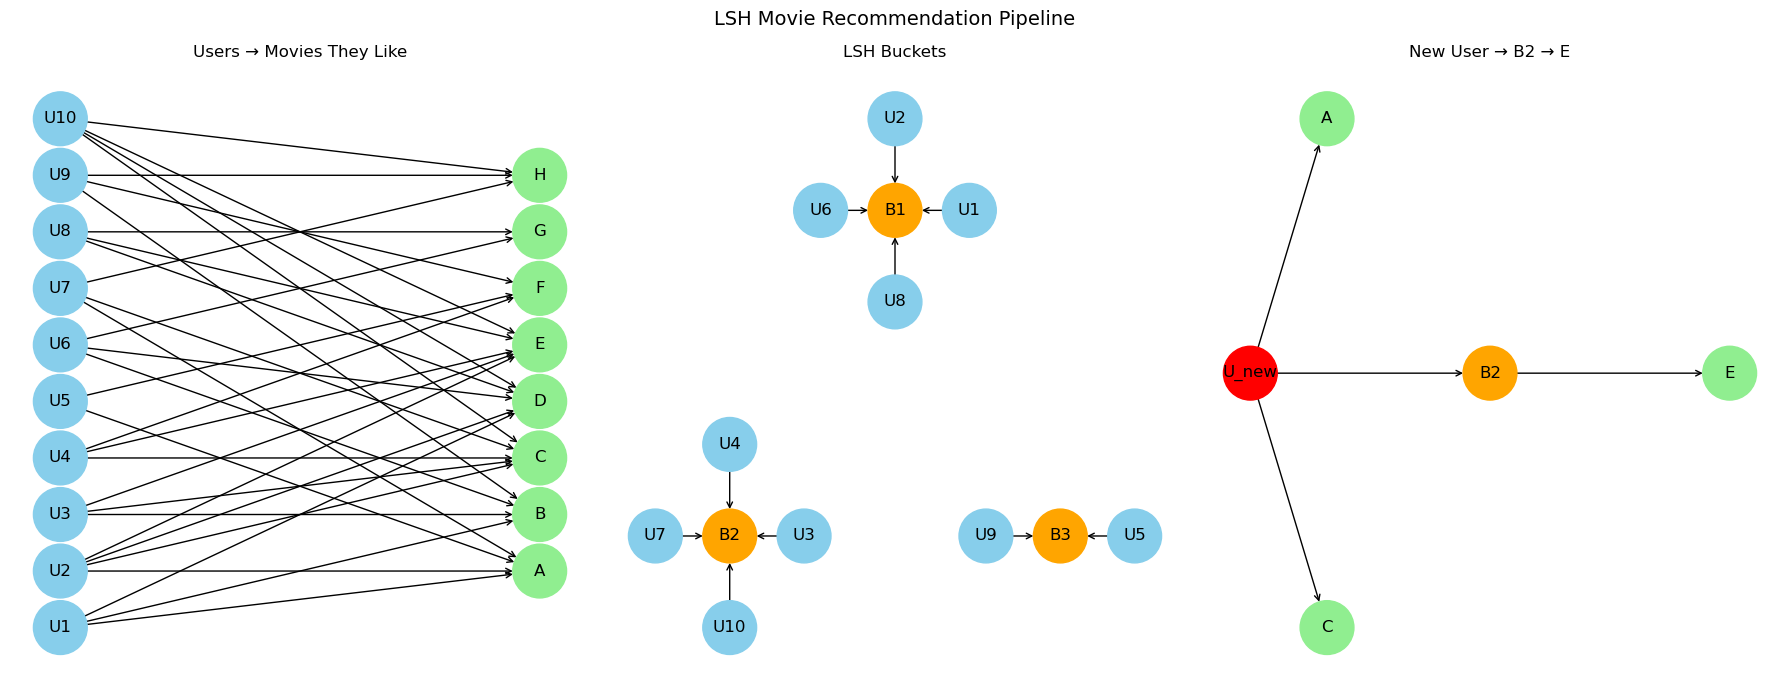

In [22]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# ----- Data -----
users = [f"U{i}" for i in range(1,11)]
movies = ["A","B","C","D","E","F","G","H"]

likes = {
    "U1":["A","B","D"],      "U2":["A","C","D","E"],
    "U3":["B","C","E"],      "U4":["C","E","F"],
    "U5":["A","F"],          "U6":["B","D","G"],
    "U7":["A","C","H"],      "U8":["D","E","G"],
    "U9":["B","F","H"],      "U10":["C","D","E","H"]
}

# LSH bucket assignment
user_bucket = {
    "U1":"B1","U2":"B1","U6":"B1","U8":"B1",
    "U3":"B2","U4":"B2","U7":"B2","U10":"B2",
    "U5":"B3","U9":"B3"
}

# New user
new_user = "U_new"
new_likes = ["A","C"]

# Bucket scoring
bucket_scores = {}
for u,b in user_bucket.items():
    bucket_scores[b] = bucket_scores.get(b,0) + len(set(new_likes)&set(likes[u]))

assign_bucket = max(bucket_scores,key=bucket_scores.get)

movies_in_bucket = [m for u,b in user_bucket.items() if b==assign_bucket for m in likes[u]]
candidates = [m for m in movies_in_bucket if m not in new_likes]
recommended_movie = max(set(candidates), key=candidates.count)

# ----- Helpers -----
def centered_positions(nodes, x):
    n = len(nodes)
    ys = np.linspace(-(n-1)/2, (n-1)/2, n)
    return {node:(x, y) for node,y in zip(nodes,ys)}

# ----- Phase 1: Users → Movies -----
pos_users = centered_positions(users, -2.5)
pos_movies = centered_positions(movies, 2.5)

# ----- Phase 2: Triangle bucket clusters -----
bucket_centers = {
    "B1": (0, 2),
    "B2": (-2, -1.2),
    "B3": (2, -1.2)
}

pos_clusters = {}
radius = 0.9

for b,(bx,by) in bucket_centers.items():
    cluster_users = [u for u in users if user_bucket[u]==b]
    angles = np.linspace(0, 2*np.pi, len(cluster_users), endpoint=False)
    for u,theta in zip(cluster_users, angles):
        pos_clusters[u] = (bx + radius*np.cos(theta), by + radius*np.sin(theta))
    pos_clusters[b] = (bx,by)

# ----- Phase 3: New user flow -----
pos_stage3 = {
    new_user:(-2.5,0),
    assign_bucket:(0,0),
    recommended_movie:(2.5,0)
}
pos_new_likes = {m:(-1.7, 0.3 if i==0 else -0.3) for i,m in enumerate(new_likes)}

# ----- Draw Function -----
def draw_graph(ax, nodes, edges, pos, title):
    G = nx.DiGraph()
    for n,color in nodes:
        G.add_node(n, color=color)
    for u,v in edges:
        G.add_edge(u,v)
    colors = [G.nodes[n]["color"] for n in G.nodes()]
    nx.draw(G, pos, ax=ax, with_labels=True, node_color=colors,
            node_size=1500, arrows=True, arrowstyle="->")
    ax.set_title(title)
    ax.axis("off")

fig, ax = plt.subplots(1,3, figsize=(18,7))
plt.suptitle("LSH Movie Recommendation Pipeline", fontsize=14)

# ----- LEFT PANEL -----
nodes1 = [(u,"skyblue") for u in users] + [(m,"lightgreen") for m in movies]
edges1 = [(u,m) for u in likes for m in likes[u]]
draw_graph(ax[0], nodes1, edges1, {**pos_users, **pos_movies}, "Users → Movies They Like")

# ----- MIDDLE PANEL -----
nodes2 = [(b,"orange") for b in bucket_centers] + [(u,"skyblue") for u in users]
edges2 = [(u,user_bucket[u]) for u in users]
draw_graph(ax[1], nodes2, edges2, pos_clusters, "LSH Buckets")

# ----- RIGHT PANEL -----
nodes3 = [(new_user,"red"), (assign_bucket,"orange"), (recommended_movie,"lightgreen")] \
         + [(m,"lightgreen") for m in new_likes]
edges3 = [(new_user,m) for m in new_likes] \
         + [(new_user,assign_bucket), (assign_bucket,recommended_movie)]
draw_graph(ax[2], nodes3, edges3, {**pos_stage3, **pos_new_likes},
           f"New User → {assign_bucket} → {recommended_movie}")

plt.tight_layout()
plt.show()


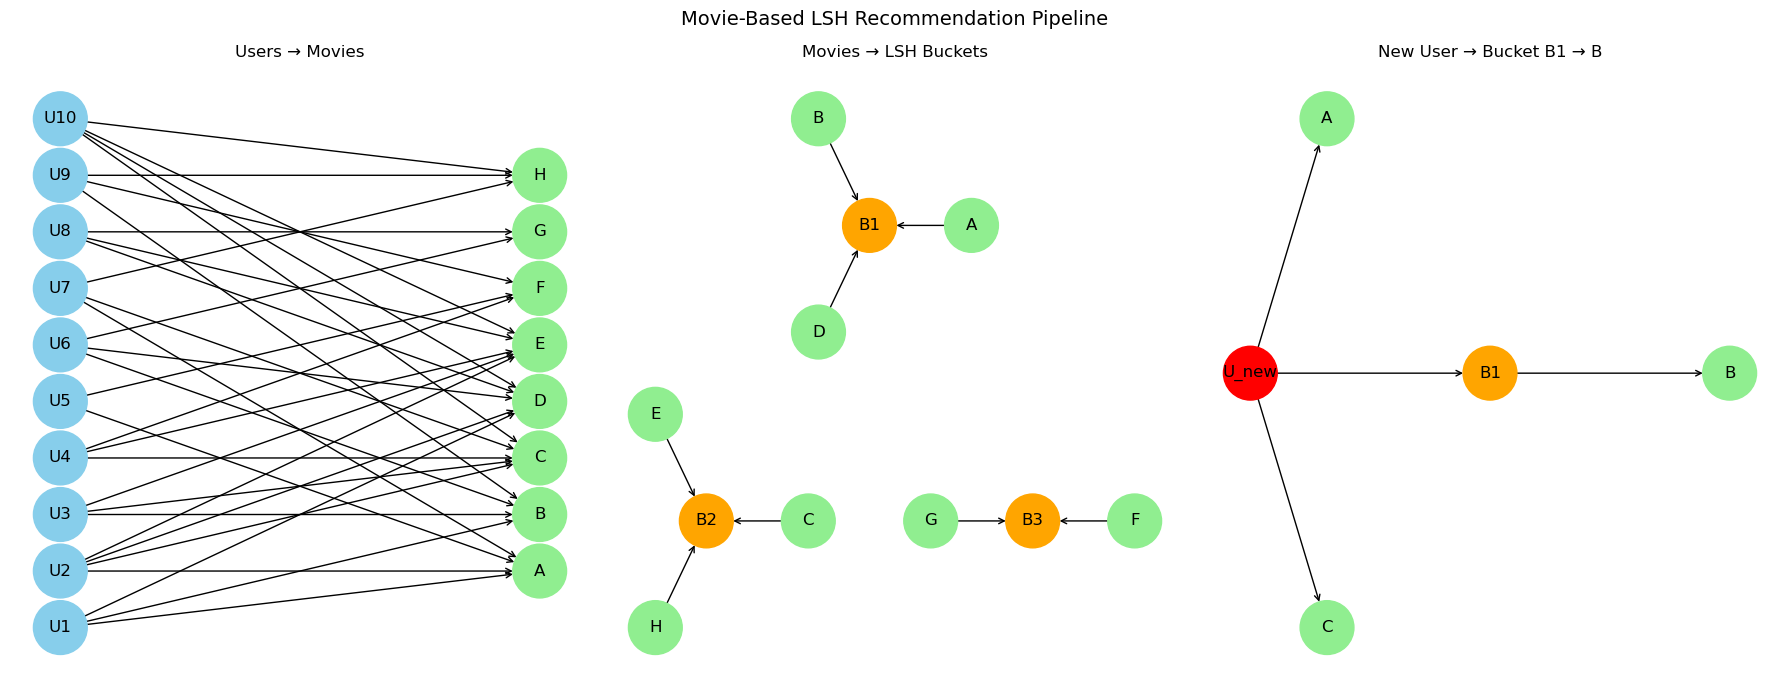

In [28]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# -------- Data --------
users = [f"U{i}" for i in range(1,11)]
movies = ["A","B","C","D","E","F","G","H"]

likes = {
    "U1":["A","B","D"], "U2":["A","C","D","E"],
    "U3":["B","C","E"], "U4":["C","E","F"],
    "U5":["A","F"], "U6":["B","D","G"],
    "U7":["A","C","H"], "U8":["D","E","G"],
    "U9":["B","F","H"], "U10":["C","D","E","H"]
}

# Movie LSH buckets (example clustering)
movie_bucket = {
    "A":"B1","B":"B1","D":"B1",
    "C":"B2","E":"B2","H":"B2",
    "F":"B3","G":"B3"
}

# new user profile
new_user = "U_new"
new_likes = ["A","C"]

# determine bucket by overlap
bucket_scores = {}
for m in new_likes:
    b = movie_bucket[m]
    bucket_scores[b] = bucket_scores.get(b, 0) + 1

assign_bucket = max(bucket_scores, key=bucket_scores.get)

# candidate movies from bucket
bucket_movies = [m for m,b in movie_bucket.items() if b==assign_bucket]
candidates = [m for m in bucket_movies if m not in new_likes]
recommended_movie = candidates[0]  # simple pick

# -------- Layout helpers --------
def centered_positions(nodes, x):
    n = len(nodes)
    ys = np.linspace(-(n-1)/2, (n-1)/2, n)
    return {node:(x, y) for node,y in zip(nodes,ys)}

# Panel 1 positions
pos_users = centered_positions(users, -2.5)
pos_movies_left = centered_positions(movies, 2.5)

# Panel 2: triangle bucket centers (moved closer)
bucket_centers = {
    "B1": (0.0, 1.0),
    "B2": (-0.8, -0.2),
    "B3": (0.8, -0.2)
}


pos_movies_mid = {}
radius=0.5
for b,(bx,by) in bucket_centers.items():
    cluster_movies = [m for m in movies if movie_bucket[m]==b]
    angles = np.linspace(0,2*np.pi,len(cluster_movies), endpoint=False)
    for m,theta in zip(cluster_movies, angles):
        pos_movies_mid[m] = (bx + radius*np.cos(theta), by + radius*np.sin(theta))
    pos_movies_mid[b] = (bx,by)

# Panel 3
pos_stage3 = {new_user:(-2.5,0), assign_bucket:(0,0), recommended_movie:(2.5,0)}
pos_new_likes = {m:(-1.7, 0.4 if i==0 else -0.4) for i,m in enumerate(new_likes)}

# -------- Draw utility --------
def draw(ax, nodes, edges, pos, title):
    G = nx.DiGraph()
    for n,c in nodes:
        G.add_node(n, color=c)
    for u,v in edges:
        G.add_edge(u,v)
    colors = [G.nodes[n]["color"] for n in G.nodes()]
    nx.draw(G, pos, ax=ax, with_labels=True, node_color=colors, node_size=1500,
            arrows=True, arrowstyle="->")
    ax.set_title(title)
    ax.axis("off")

fig,ax = plt.subplots(1,3, figsize=(18,7))
plt.suptitle("Movie-Based LSH Recommendation Pipeline", fontsize=14)

# --- Panel 1 ---
nodes1 = [(u,"skyblue") for u in users] + [(m,"lightgreen") for m in movies]
edges1 = [(u,m) for u in likes for m in likes[u]]
draw(ax[0], nodes1, edges1, {**pos_users, **pos_movies_left},
     "Users → Movies")

# --- Panel 2 (triangle LSH buckets) ---
nodes2 = [(b,"orange") for b in bucket_centers] + [(m,"lightgreen") for m in movies]
edges2 = [(m, movie_bucket[m]) for m in movies]
draw(ax[1], nodes2, edges2, pos_movies_mid, "Movies → LSH Buckets")

# --- Panel 3 ---
nodes3 = [(new_user,"red"), (assign_bucket,"orange"), (recommended_movie,"lightgreen")] \
         + [(m,"lightgreen") for m in new_likes]
edges3 = [(new_user,m) for m in new_likes] \
         + [(new_user,assign_bucket), (assign_bucket,recommended_movie)]
draw(ax[2], nodes3, edges3, {**pos_stage3, **pos_new_likes},
     f"New User → Bucket {assign_bucket} → {recommended_movie}")

plt.tight_layout()
plt.show()
